In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pickle
import spacy
import ast

import pyLDAvis
import pyLDAvis.gensim  
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)



import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to C:\Users\Devdatta
[nltk_data]     Supnekar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Devdatta
[nltk_data]     Supnekar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [6]:
# df = pd.read_csv("bbc-text.csv")
df = pd.read_csv("1st_Input_df_for_tm.csv")
df.head()

,Unnamed: 0,Session_id,Text
0,0,BillPay call with no PII,"Welcome to Vodafone, here speaking. May I get ..."
1,1,BillPay call with no PII,it. What what is the error message you're gett...
2,2,BillPay call with no PII,"code. Okay, let me just double-check. Hold on...."
3,3,BillPay call with no PII,8080. No problem at all. Here is the PIN code ...
4,4,BillPay call with no PII,That's perfect. No worries at all. Hold on. Ju...


In [7]:
df.shape

(46, 3)

In [5]:
df["text"].iloc[0]

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

In [4]:
df["category"].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [65]:
stop_words = stopwords.words('english')
file = open("stopwords/extended_stopwords.txt", "r")
stop_words.extend([line.strip() for line in file.readlines()])
file.close()
file = open("stopwords/contractions.txt", "r")
contractions = ast.literal_eval(file.read())
file.close()

In [66]:
print(df.Session_id.unique())

['BillPay call with no PII' 'Fixed call with no PII'
 'PAYG call with no PII']


In [67]:
# Convert to list
data = df.Text.values.tolist()
print(len(data))

46


In [68]:

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'"," ", sent) for sent in data]

pprint(data[0])

('Welcome to Vodafone, here speaking. May I get your name, please? How can I '
 'help')


In [69]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[0])


['welcome', 'to', 'vodafone', 'here', 'speaking', 'may', 'get', 'your', 'name', 'please', 'how', 'can', 'help']


In [70]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)# higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

2021-06-25 17:39:44,552 : INFO : collecting all words and their counts
2021-06-25 17:39:44,559 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2021-06-25 17:39:44,562 : INFO : collected 946 token types (unigram + bigrams) from a corpus of 857 words and 46 sentences
2021-06-25 17:39:44,563 : INFO : merged Phrases<946 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
2021-06-25 17:39:44,614 : INFO : Phrases lifecycle event {'msg': 'built Phrases<946 vocab, min_count=5, threshold=100, max_vocab_size=40000000> in 0.06s', 'datetime': '2021-06-25T17:39:44.613984', 'gensim': '4.0.1', 'python': '3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2021-06-25 17:39:44,618 : INFO : collecting all words and their counts
2021-06-25 17:39:44,618 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2021-06-25 17:39:44,622 : INFO : collected 946 token types (unigram + bigrams)

In [71]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

2021-06-25 17:40:04,627 : INFO : exporting phrases from Phrases<946 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
2021-06-25 17:40:04,631 : INFO : FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<0 phrases, min_count=5, threshold=100> from Phrases<946 vocab, min_count=5, threshold=100, max_vocab_size=40000000> in 0.00s', 'datetime': '2021-06-25T17:40:04.630831', 'gensim': '4.0.1', 'python': '3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2021-06-25 17:40:04,632 : INFO : exporting phrases from Phrases<946 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
2021-06-25 17:40:04,634 : INFO : FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<0 phrases, min_count=5, threshold=100> from Phrases<946 vocab, min_count=5, threshold=100, max_vocab_size=40000000> in 0.00s', 'datetime': '2021-06-25T17:40:04.634831', 'gensim': '4.0.1', 'python': '3.7.6 (default, Jan  8 202

In [72]:
# See bigram example
print(bigram_mod[data_words[0]])


['welcome', 'to', 'vodafone', 'here', 'speaking', 'may', 'get', 'your', 'name', 'please', 'how', 'can', 'help']


In [73]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [74]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [75]:
print(len(data_lemmatized))

46


In [76]:
counter = 0
empty_idx = []
for idx , (raw, clean) in enumerate(zip(data, data_lemmatized)):
    print(idx, "---"*10)
    print("raw: ",raw)
    clean_text = " ".join(clean)
    print("clean: ", clean_text )
    print("len", len(clean_text))
    if len(clean_text) == 0:
        counter = counter + 1
        empty_idx.append(idx)
    print()
    
print("No of empty strings: ", counter)
print("empty idx: ", empty_idx)

0 ------------------------------
raw:  Welcome to Vodafone, here speaking. May I get your name, please? How can I help
clean:  vodafone speak
len 14

1 ------------------------------
raw:  it. What what is the error message you re getting actually
clean:  error message
len 13

2 ------------------------------
raw:  code. Okay, let me just double-check. Hold on. The average payments every month
clean:  code double check hold average payment
len 38

3 ------------------------------
raw:  8080. No problem at all. Here is the PIN code for the security of the accounts next time. This might be just handy for you. Okay, and do you have access to the online account as well? My
clean:  problem pin code security account time handy access online account
len 66

4 ------------------------------
raw:  That s perfect. No worries at all. Hold on. Just 1 second. What type of phone you have
clean:  perfect worry hold type phone
len 29

5 ------------------------------
raw:  6. Yep. That s perfect. And 

In [77]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[0])

2021-06-25 17:40:46,121 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-06-25 17:40:46,125 : INFO : built Dictionary(131 unique tokens: ['speak', 'vodafone', 'error', 'message', 'average']...) from 46 documents (total 206 corpus positions)
2021-06-25 17:40:46,127 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(131 unique tokens: ['speak', 'vodafone', 'error', 'message', 'average']...) from 46 documents (total 206 corpus positions)", 'datetime': '2021-06-25T17:40:46.127601', 'gensim': '4.0.1', 'python': '3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


[(0, 1), (1, 1)]


In [78]:
len(corpus)

46

In [79]:
id2word[0]

'speak'

In [87]:
len(id2word)

131

In [80]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('speak', 1), ('vodafone', 1)]]

In [81]:
def tune_model(dictionary, corpus, texts, limit, start=2, step=1):
    
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(round(coherencemodel.get_coherence(),3))

    return model_list, coherence_values

In [82]:
# Can take a long time to run
model_list, coherence_values = tune_model(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=8, step=1)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]2021-06-25 17:41:27,750 : INFO : using autotuned alpha, starting with [0.5, 0.5]
2021-06-25 17:41:27,752 : INFO : using symmetric eta at 0.5
2021-06-25 17:41:27,767 : INFO : using serial LDA version on this node
2021-06-25 17:41:27,777 : INFO : running online (multi-pass) LDA training, 2 topics, 10 passes over the supplied corpus of 46 documents, updating model once every 46 documents, evaluating perplexity every 46 documents, iterating 50x with a convergence threshold of 0.001000
2021-06-25 17:41:27,832 : INFO : -5.773 per-word bound, 54.7 perplexity estimate based on a held-out corpus of 46 documents with 206 words
2021-06-25 17:41:27,834 : INFO : PROGRESS: pass 0, at document #46/46
2021-06-25 17:41:27,869 : INFO : optimized alpha [0.6274307, 0.66736495]
2021-06-25 17:41:27,874 : INFO : topic #0 (0.627): 0.040*"setting" + 0.019*"tech" + 0.019*"support" + 0.019*"chec

2021-06-25 17:41:28,100 : INFO : topic diff=0.005950, rho=0.301511
2021-06-25 17:41:28,102 : INFO : LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=131, num_topics=2, decay=0.5, chunksize=100) in 0.33s', 'datetime': '2021-06-25T17:41:28.102338', 'gensim': '4.0.1', 'python': '3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2021-06-25 17:41:28,110 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-06-25 17:41:34,285 : INFO : 7 accumulators retrieved from output queue
2021-06-25 17:41:34,333 : INFO : accumulated word occurrence stats for 32 virtual documents
 17%|██████████████                                                                      | 1/6 [00:06<00:33,  6.67s/it]2021-06-25 17:41:34,410 : INFO : using autotuned alpha, starting with [0.33333334, 0.33333334, 0.33333334]
2021-06-25 17:41:34,411 : INFO : using 

2021-06-25 17:41:34,596 : INFO : topic diff=0.003673, rho=0.353553
2021-06-25 17:41:34,607 : INFO : -5.349 per-word bound, 40.8 perplexity estimate based on a held-out corpus of 46 documents with 206 words
2021-06-25 17:41:34,608 : INFO : PROGRESS: pass 7, at document #46/46
2021-06-25 17:41:34,615 : INFO : optimized alpha [0.12995787, 0.22053961, 0.13566309]
2021-06-25 17:41:34,616 : INFO : topic #0 (0.130): 0.052*"setting" + 0.028*"check" + 0.016*"tech" + 0.016*"support" + 0.016*"work" + 0.016*"morning" + 0.016*"tonight" + 0.016*"gigabyte" + 0.016*"inquire" + 0.016*"offer"
2021-06-25 17:41:34,617 : INFO : topic #1 (0.221): 0.049*"call" + 0.043*"account" + 0.036*"number" + 0.029*"mobile" + 0.022*"code" + 0.022*"honest" + 0.016*"phone" + 0.016*"check" + 0.016*"hold" + 0.016*"time"
2021-06-25 17:41:34,618 : INFO : topic #2 (0.136): 0.022*"morning" + 0.022*"lose" + 0.022*"speak" + 0.022*"perfect" + 0.022*"enter" + 0.022*"top" + 0.022*"phone" + 0.022*"password" + 0.022*"setting" + 0.013*"

2021-06-25 17:41:38,363 : INFO : PROGRESS: pass 3, at document #46/46
2021-06-25 17:41:38,371 : INFO : optimized alpha [0.15782821, 0.23062134, 0.14624098, 0.123279646]
2021-06-25 17:41:38,372 : INFO : topic #0 (0.158): 0.055*"setting" + 0.042*"check" + 0.029*"number" + 0.016*"apologize" + 0.016*"tech" + 0.016*"support" + 0.016*"work" + 0.016*"tonight" + 0.016*"morning" + 0.016*"gigabyte"
2021-06-25 17:41:38,373 : INFO : topic #1 (0.231): 0.059*"call" + 0.046*"account" + 0.034*"mobile" + 0.026*"number" + 0.025*"code" + 0.018*"phone" + 0.018*"honest" + 0.018*"fi" + 0.018*"knock" + 0.018*"hold"
2021-06-25 17:41:38,373 : INFO : topic #2 (0.146): 0.033*"morning" + 0.033*"lose" + 0.033*"perfect" + 0.033*"speak" + 0.019*"setting" + 0.018*"leave" + 0.018*"datum" + 0.018*"top" + 0.018*"minute" + 0.018*"mind"
2021-06-25 17:41:38,374 : INFO : topic #3 (0.123): 0.033*"enter" + 0.033*"password" + 0.033*"talk" + 0.031*"access" + 0.030*"online" + 0.026*"account" + 0.018*"setting" + 0.018*"reset" + 0

2021-06-25 17:41:38,504 : INFO : topic #3 (0.086): 0.032*"enter" + 0.032*"password" + 0.032*"talk" + 0.032*"access" + 0.032*"online" + 0.026*"account" + 0.018*"reset" + 0.018*"setting" + 0.018*"uninstall" + 0.018*"app"
2021-06-25 17:41:38,505 : INFO : topic diff=0.003180, rho=0.301511
2021-06-25 17:41:38,505 : INFO : LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=131, num_topics=4, decay=0.5, chunksize=100) in 0.26s', 'datetime': '2021-06-25T17:41:38.505063', 'gensim': '4.0.1', 'python': '3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2021-06-25 17:41:38,507 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-06-25 17:41:42,033 : INFO : 7 accumulators retrieved from output queue
2021-06-25 17:41:42,046 : INFO : accumulated word occurrence stats for 36 virtual documents
 50%|█████████████████████████████████████████

2021-06-25 17:41:42,330 : INFO : topic #3 (0.113): 0.045*"apologize" + 0.031*"talk" + 0.031*"password" + 0.031*"account" + 0.031*"enter" + 0.017*"agent" + 0.017*"top" + 0.017*"text" + 0.017*"prior" + 0.017*"day"
2021-06-25 17:41:42,333 : INFO : topic #4 (0.133): 0.094*"setting" + 0.033*"number" + 0.018*"check" + 0.018*"work" + 0.018*"morning" + 0.018*"edition" + 0.018*"cool" + 0.018*"wage" + 0.018*"gigabyte" + 0.018*"tonight"
2021-06-25 17:41:42,335 : INFO : topic diff=0.008704, rho=0.408248
2021-06-25 17:41:42,348 : INFO : -5.553 per-word bound, 46.9 perplexity estimate based on a held-out corpus of 46 documents with 206 words
2021-06-25 17:41:42,349 : INFO : PROGRESS: pass 5, at document #46/46
2021-06-25 17:41:42,356 : INFO : optimized alpha [0.092652425, 0.17480598, 0.10815417, 0.10690075, 0.127257]
2021-06-25 17:41:42,358 : INFO : topic #0 (0.093): 0.034*"check" + 0.034*"jack" + 0.034*"dog" + 0.034*"wonderful" + 0.034*"speak" + 0.034*"broadband" + 0.034*"error" + 0.034*"message" +

2021-06-25 17:41:50,452 : INFO : 7 accumulators retrieved from output queue
2021-06-25 17:41:50,468 : INFO : accumulated word occurrence stats for 39 virtual documents
 67%|████████████████████████████████████████████████████████                            | 4/6 [00:22<00:12,  6.22s/it]2021-06-25 17:41:50,648 : INFO : using autotuned alpha, starting with [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667]
2021-06-25 17:41:50,649 : INFO : using symmetric eta at 0.16666666666666666
2021-06-25 17:41:50,650 : INFO : using serial LDA version on this node
2021-06-25 17:41:50,651 : INFO : running online (multi-pass) LDA training, 6 topics, 10 passes over the supplied corpus of 46 documents, updating model once every 46 documents, evaluating perplexity every 46 documents, iterating 50x with a convergence threshold of 0.001000
2021-06-25 17:41:50,668 : INFO : -8.824 per-word bound, 453.1 perplexity estimate based on a held-out corpus of 46 documents with 206 words
2021-06-2

2021-06-25 17:41:50,817 : INFO : PROGRESS: pass 5, at document #46/46
2021-06-25 17:41:50,823 : INFO : optimized alpha [0.08201362, 0.15778737, 0.083784655, 0.09754661, 0.108723134, 0.11715505]
2021-06-25 17:41:50,824 : INFO : topic #0 (0.082): 0.042*"dog" + 0.042*"broadband" + 0.042*"error" + 0.042*"message" + 0.042*"bother" + 0.042*"check" + 0.006*"setting" + 0.006*"hear" + 0.006*"call" + 0.006*"number"
2021-06-25 17:41:50,825 : INFO : topic #2 (0.084): 0.032*"put" + 0.032*"customer" + 0.032*"tech" + 0.032*"care" + 0.032*"support" + 0.032*"send" + 0.032*"morning" + 0.032*"night" + 0.032*"work" + 0.032*"appointment"
2021-06-25 17:41:50,825 : INFO : topic #4 (0.109): 0.094*"setting" + 0.058*"number" + 0.021*"morning" + 0.021*"work" + 0.021*"edition" + 0.021*"cool" + 0.021*"tonight" + 0.021*"wage" + 0.021*"check" + 0.021*"credit"
2021-06-25 17:41:50,826 : INFO : topic #5 (0.117): 0.028*"lose" + 0.028*"reset" + 0.028*"phone" + 0.028*"password" + 0.028*"enter" + 0.015*"apologize" + 0.015*

2021-06-25 17:41:59,366 : INFO : using serial LDA version on this node
2021-06-25 17:41:59,367 : INFO : running online (multi-pass) LDA training, 7 topics, 10 passes over the supplied corpus of 46 documents, updating model once every 46 documents, evaluating perplexity every 46 documents, iterating 50x with a convergence threshold of 0.001000
2021-06-25 17:41:59,383 : INFO : -9.781 per-word bound, 880.1 perplexity estimate based on a held-out corpus of 46 documents with 206 words
2021-06-25 17:41:59,384 : INFO : PROGRESS: pass 0, at document #46/46
2021-06-25 17:41:59,398 : INFO : optimized alpha [0.1181071, 0.15242732, 0.118233725, 0.11479975, 0.121955395, 0.12633555, 0.12545362]
2021-06-25 17:41:59,399 : INFO : topic #3 (0.115): 0.067*"honest" + 0.036*"consult" + 0.036*"apologize" + 0.036*"top" + 0.036*"agent" + 0.036*"case" + 0.036*"coverage" + 0.036*"text" + 0.036*"prior" + 0.036*"talk"
2021-06-25 17:41:59,399 : INFO : topic #0 (0.118): 0.033*"tech" + 0.033*"call" + 0.033*"support"

2021-06-25 17:41:59,543 : INFO : topic #2 (0.086): 0.033*"customer" + 0.033*"put" + 0.033*"tech" + 0.033*"morning" + 0.033*"support" + 0.033*"work" + 0.033*"care" + 0.033*"speak" + 0.033*"night" + 0.033*"appointment"
2021-06-25 17:41:59,544 : INFO : topic #5 (0.094): 0.047*"lose" + 0.026*"reset" + 0.026*"phone" + 0.025*"datum" + 0.025*"tech" + 0.025*"top" + 0.025*"support" + 0.025*"morning" + 0.025*"colleague" + 0.025*"inconvenience"
2021-06-25 17:41:59,545 : INFO : topic #6 (0.098): 0.038*"setting" + 0.038*"password" + 0.037*"enter" + 0.020*"speaker" + 0.020*"cuz" + 0.020*"white" + 0.020*"send" + 0.020*"referred" + 0.020*"store" + 0.020*"understand"
2021-06-25 17:41:59,546 : INFO : topic #1 (0.154): 0.066*"call" + 0.066*"account" + 0.034*"number" + 0.023*"mobile" + 0.023*"phone" + 0.023*"code" + 0.023*"hold" + 0.023*"check" + 0.023*"time" + 0.023*"fi"
2021-06-25 17:41:59,546 : INFO : topic diff=0.014242, rho=0.377964
2021-06-25 17:41:59,557 : INFO : -5.671 per-word bound, 50.9 perplex

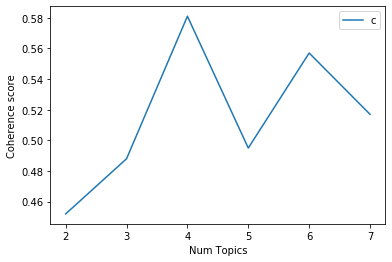

In [83]:
# Show graph
limit=8; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [84]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.452
Num Topics = 3  has Coherence Value of 0.488
Num Topics = 4  has Coherence Value of 0.581
Num Topics = 5  has Coherence Value of 0.495
Num Topics = 6  has Coherence Value of 0.557
Num Topics = 7  has Coherence Value of 0.517


In [85]:
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

2021-06-25 17:42:31,215 : INFO : topic #0 (0.118): 0.055*"setting" + 0.042*"check" + 0.029*"number" + 0.016*"work" + 0.016*"apologize" + 0.016*"morning" + 0.016*"tonight" + 0.016*"gigabyte" + 0.016*"inquire" + 0.016*"troubleshoot"
2021-06-25 17:42:31,216 : INFO : topic #1 (0.187): 0.059*"call" + 0.046*"account" + 0.035*"mobile" + 0.026*"number" + 0.026*"code" + 0.018*"phone" + 0.018*"honest" + 0.018*"hold" + 0.018*"datum" + 0.018*"fi"
2021-06-25 17:42:31,217 : INFO : topic #2 (0.106): 0.033*"morning" + 0.033*"lose" + 0.033*"speak" + 0.033*"perfect" + 0.018*"setting" + 0.018*"top" + 0.018*"leave" + 0.018*"mind" + 0.018*"put" + 0.018*"customer"
2021-06-25 17:42:31,218 : INFO : topic #3 (0.086): 0.032*"enter" + 0.032*"password" + 0.032*"talk" + 0.032*"access" + 0.032*"online" + 0.026*"account" + 0.018*"reset" + 0.018*"setting" + 0.018*"uninstall" + 0.018*"app"


[(0,
  '0.055*"setting" + 0.042*"check" + 0.029*"number" + 0.016*"work" + '
  '0.016*"apologize" + 0.016*"morning" + 0.016*"tonight" + 0.016*"gigabyte" + '
  '0.016*"inquire" + 0.016*"troubleshoot"'),
 (1,
  '0.059*"call" + 0.046*"account" + 0.035*"mobile" + 0.026*"number" + '
  '0.026*"code" + 0.018*"phone" + 0.018*"honest" + 0.018*"hold" + '
  '0.018*"datum" + 0.018*"fi"'),
 (2,
  '0.033*"morning" + 0.033*"lose" + 0.033*"speak" + 0.033*"perfect" + '
  '0.018*"setting" + 0.018*"top" + 0.018*"leave" + 0.018*"mind" + 0.018*"put" '
  '+ 0.018*"customer"'),
 (3,
  '0.032*"enter" + 0.032*"password" + 0.032*"talk" + 0.032*"access" + '
  '0.032*"online" + 0.026*"account" + 0.018*"reset" + 0.018*"setting" + '
  '0.018*"uninstall" + 0.018*"app"')]


In [86]:
x = optimal_model.show_topics(num_topics=5, num_words=10, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Below Code Prints Topics and Words
for topic, words in topics_words:
    print(str(topic) + "::" + str(words))
print()

print("---------------------")

0::['setting', 'check', 'number', 'work', 'apologize', 'morning', 'tonight', 'gigabyte', 'inquire', 'troubleshoot']
1::['call', 'account', 'mobile', 'number', 'code', 'phone', 'honest', 'hold', 'datum', 'fi']
2::['morning', 'lose', 'speak', 'perfect', 'setting', 'top', 'leave', 'mind', 'put', 'customer']
3::['enter', 'password', 'talk', 'access', 'online', 'account', 'reset', 'setting', 'uninstall', 'app']

---------------------


In [90]:
len(optimal_model[corpus])

46

In [92]:
for i in [13, 18, 27, 35, 40, 44, 45]:
    print(optimal_model[corpus[i]])
    

([(0, 0.23788895), (1, 0.37630972), (2, 0.21313566), (3, 0.17266567)], [], [])
([(0, 0.23788895), (1, 0.37630972), (2, 0.21313566), (3, 0.17266567)], [], [])
([(0, 0.23788895), (1, 0.37630972), (2, 0.21313566), (3, 0.17266567)], [], [])
([(0, 0.23788895), (1, 0.37630972), (2, 0.21313566), (3, 0.17266567)], [], [])
([(0, 0.23788895), (1, 0.37630972), (2, 0.21313566), (3, 0.17266567)], [], [])
([(0, 0.23788895), (1, 0.37630972), (2, 0.21313566), (3, 0.17266567)], [], [])
([(0, 0.23788895), (1, 0.37630972), (2, 0.21313566), (3, 0.17266567)], [], [])


In [93]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        
        row = sorted(row[0], key=lambda x: x[1], reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)
df_topic_sents_keywords.head(45)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
0,2.0,0.8437,"morning, lose, speak, perfect, setting, top, l...","Welcome to Vodafone, here speaking. May I get ..."
1,0.0,0.8486,"setting, check, number, work, apologize, morni...",it. What what is the error message you re gett...
2,1.0,0.9524,"call, account, mobile, number, code, phone, ho...","code. Okay, let me just double-check. Hold on...."
3,3.0,0.5028,"enter, password, talk, access, online, account...",8080. No problem at all. Here is the PIN code ...
4,2.0,0.9286,"morning, lose, speak, perfect, setting, top, l...",That s perfect. No worries at all. Hold on. Ju...
5,1.0,0.9813,"call, account, mobile, number, code, phone, ho...",6. Yep. That s perfect. And what about the is ...
6,1.0,0.9524,"call, account, mobile, number, code, phone, ho...",you. Can you go to settings just you can put t...
7,1.0,0.7933,"call, account, mobile, number, code, phone, ho...",you want to put this call on
8,1.0,0.9312,"call, account, mobile, number, code, phone, ho...",Okay. Now you need to press the middle button ...
9,0.0,0.8485,"setting, check, number, work, apologize, morni...","discussions. Yes, ma am settings. Yeah, and th..."


In [94]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Topic_No', 'Topic_Perc_Contrib', 'Topic_Keywords', 'Text']

final_df = df_dominant_topic.drop("Document_No", axis=1)

# add clean text Show
clean_text = [ " ".join(i) for i in texts]
final_df["Clean_Text"] = clean_text

# show
final_df.head(46)

,Topic_No,Topic_Perc_Contrib,Topic_Keywords,Text,Clean_Text
0,2.0,0.8437,"morning, lose, speak, perfect, setting, top, l...","Welcome to Vodafone, here speaking. May I get ...",vodafone speak
1,0.0,0.8486,"setting, check, number, work, apologize, morni...",it. What what is the error message you re gett...,error message
2,1.0,0.9524,"call, account, mobile, number, code, phone, ho...","code. Okay, let me just double-check. Hold on....",code double check hold average payment
3,3.0,0.5028,"enter, password, talk, access, online, account...",8080. No problem at all. Here is the PIN code ...,problem pin code security account time handy a...
4,2.0,0.9286,"morning, lose, speak, perfect, setting, top, l...",That s perfect. No worries at all. Hold on. Ju...,perfect worry hold type phone
5,1.0,0.9813,"call, account, mobile, number, code, phone, ho...",6. Yep. That s perfect. And what about the is ...,perfect sky spotify tire cuss sport red phone ...
6,1.0,0.9524,"call, account, mobile, number, code, phone, ho...",you. Can you go to settings just you can put t...,setting code speaker cuz knock white
7,1.0,0.7933,"call, account, mobile, number, code, phone, ho...",you want to put this call on,call
8,1.0,0.9312,"call, account, mobile, number, code, phone, ho...",Okay. Now you need to press the middle button ...,press middle button button
9,0.0,0.8485,"setting, check, number, work, apologize, morni...","discussions. Yes, ma am settings. Yeah, and th...",discussion setting


In [95]:
final_df["Topic_No"].value_counts()

1.0    23
0.0    10
2.0     8
3.0     5
Name: Topic_No, dtype: int64

In [96]:
final_df.columns

Index(['Topic_No', 'Topic_Perc_Contrib', 'Topic_Keywords', 'Text',
       'Clean_Text'],
      dtype='object')

# Prediction for new data 

In [97]:
df_test = pd.read_csv("bbc-text.csv")
df_test.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [98]:


def clean_pipeline(data):    
    
    print(len(data))

    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
    data = [re.sub('\s+', ' ', sent) for sent in data]
    data = [re.sub("\'"," ", sent) for sent in data]
    
    data_words = list(sent_to_words(data))
    data_words_nostops = remove_stopwords(data_words)
    data_words_bigrams = make_bigrams(data_words_nostops)

    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    

    return data_lemmatized

In [99]:
raw_text = df_test.text.values.tolist()
clean_text = clean_pipeline(raw_text)

2225


In [100]:
for idx , (raw, clean) in enumerate(zip(raw_text, clean_text)):
    print("--"*40)
    print("raw: ",raw)
    print()
    print("clean: ", " ".join(clean))
    print()
    if idx == 15:
        break

--------------------------------------------------------------------------------
raw:  tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the

# before updating the dictonary 

In [102]:
len(id2word)

131

In [103]:
def bow_features_pipeline(tokenized_docs, dictionary):
    text_bow_features = [dictionary.doc2bow(text) 
                              for text in tokenized_docs]
    return text_bow_features

norm_bow_features = bow_features_pipeline(tokenized_docs=clean_data, dictionary=id2word)

In [104]:
len(norm_bow_features)

2225

In [106]:
idx = 3

print("test text: ", clean_data[idx])
print("bow test: ", norm_bow_features[idx])
print()
print("len of test text: ",  len(clean_data[idx]))
print("bow len: ", len(norm_bow_features[idx]))


test text:  ['yeade', 'face', 'newcastle', 'fa', 'cup', 'premiership', 'side', 'newcastle', 'unite', 'face', 'trip', 'ryman', 'premier', 'league', 'leader', 'yeade', 'fa', 'cup', 'round', 'game', 'arguably', 'highlight', 'draw', 'potential', 'money', 'spinner', 'league', 'yeading', 'beat', 'slough', 'round', 'conference', 'side', 'exeter', 'city', 'knock', 'doncaster', 'travel', 'trafford', 'meet', 'holder', 'manchester', 'united', 'arsenal', 'draw', 'stoke', 'chelsea', 'play', 'host', 'scunthorpe', 'league', 'side', 'draw', 'hinckley', 'unite', 'hold', 'brentford', 'goalless', 'draw', 'meet', 'league', 'leader', 'luton', 'win', 'replay', 'martin', 'allen', 'team', 'griffin', 'park', 'number', 'premiership', 'team', 'face', 'difficult', 'game', 'championship', 'side', 'weekend', 'everton', 'visit', 'plymouth', 'liverpool', 'travel', 'burnley', 'crystal', 'palace', 'sunderland', 'fulham', 'face', 'carle', 'cup', 'semi', 'finalist', 'watford', 'bolton', 'meet', 'ipswich', 'aston', 'villa

# update the dictonary 

In [108]:
id2word.add_documents(clean_text)

2021-06-25 18:04:12,175 : INFO : adding document #0 to Dictionary(131 unique tokens: ['speak', 'vodafone', 'error', 'message', 'average']...)
2021-06-25 18:04:12,570 : INFO : built Dictionary(21573 unique tokens: ['speak', 'vodafone', 'error', 'message', 'average']...) from 2271 documents (total 379840 corpus positions)


In [109]:
2225 + 46

2271

In [112]:
id2word.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

2021-06-25 18:08:41,663 : INFO : discarding 14968 tokens: [('handy', 4), ('cuss', 1), ('spotify', 1), ('tire', 3), ('cuz', 1), ('cellular', 1), ('safari', 4), ('ninja', 2), ('reset', 2), ('app', 3)]...
2021-06-25 18:08:41,665 : INFO : keeping 6605 tokens which were in no less than 5 and no more than 1135 (=50.0%) documents
2021-06-25 18:08:41,677 : INFO : resulting dictionary: Dictionary(6605 unique tokens: ['speak', 'vodafone', 'error', 'message', 'average']...)


In [114]:
id2word.compactify() # use to remove the gaps

In [115]:
len(id2word)

6605

In [149]:
# now create new corpus on updated dictinoary 
norm_bow_features = bow_features_pipeline(tokenized_docs=clean_data, dictionary=id2word)

In [150]:
idx = 3

print("test text: ", clean_data[idx])
print("bow test: ", norm_bow_features[idx])
print()
print("len of test text: ",  len(clean_data[idx]))
print("bow len: ", len(norm_bow_features[idx]))


test text:  ['yeade', 'face', 'newcastle', 'fa', 'cup', 'premiership', 'side', 'newcastle', 'unite', 'face', 'trip', 'ryman', 'premier', 'league', 'leader', 'yeade', 'fa', 'cup', 'round', 'game', 'arguably', 'highlight', 'draw', 'potential', 'money', 'spinner', 'league', 'yeading', 'beat', 'slough', 'round', 'conference', 'side', 'exeter', 'city', 'knock', 'doncaster', 'travel', 'trafford', 'meet', 'holder', 'manchester', 'united', 'arsenal', 'draw', 'stoke', 'chelsea', 'play', 'host', 'scunthorpe', 'league', 'side', 'draw', 'hinckley', 'unite', 'hold', 'brentford', 'goalless', 'draw', 'meet', 'league', 'leader', 'luton', 'win', 'replay', 'martin', 'allen', 'team', 'griffin', 'park', 'number', 'premiership', 'team', 'face', 'difficult', 'game', 'championship', 'side', 'weekend', 'everton', 'visit', 'plymouth', 'liverpool', 'travel', 'burnley', 'crystal', 'palace', 'sunderland', 'fulham', 'face', 'carle', 'cup', 'semi', 'finalist', 'watford', 'bolton', 'meet', 'ipswich', 'aston', 'villa

# update the model 


In [158]:
optimal_model.update?

In [157]:
dir(optimal_model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adapt_by_suffix',
 '_apply',
 '_load_specials',
 '_save_specials',
 '_smart_save',
 'add_lifecycle_event',
 'alpha',
 'bound',
 'callbacks',
 'chunksize',
 'clear',
 'decay',
 'diff',
 'dispatcher',
 'distributed',
 'do_estep',
 'do_mstep',
 'dtype',
 'eta',
 'eval_every',
 'expElogbeta',
 'gamma_threshold',
 'get_document_topics',
 'get_term_topics',
 'get_topic_terms',
 'get_topics',
 'id2word',
 'inference',
 'init_dir_prior',
 'iterations',
 'lifecycle_events',
 'load',
 'log_perplexity',
 'minimum_phi_value',
 'minimum_probability',
 'num_terms',
 'num_topics',
 'num_updates',
 'numworkers',
 'offse

In [155]:
optimal_model.update(
    norm_bow_features
)

print("[INFO] Model updated succefully..")

2021-06-25 18:55:46,512 : INFO : running online (multi-pass) LDA training, 4 topics, 10 passes over the supplied corpus of 2225 documents, updating model once every 100 documents, evaluating perplexity every 1000 documents, iterating 50x with a convergence threshold of 0.001000
2021-06-25 18:55:46,513 : INFO : PROGRESS: pass 0, at document #100/2225


IndexError: index 131 is out of bounds for axis 1 with size 131

In [156]:
raw_text = df_test.text.values.tolist()
df_topic_sents_keywords_test = format_topics_sentences(ldamodel=optimal_model, corpus=norm_bow_features, texts=raw_text)
df_topic_sents_keywords_test.head(45)

IndexError: index 131 is out of bounds for axis 1 with size 131

In [42]:
df_topic_sents_keywords_test["Dominant_Topic"].value_counts()

1.0    1166
2.0     473
0.0     332
3.0     254
Name: Dominant_Topic, dtype: int64

# new data

In [45]:
# Data ingenstion

import os
import json
import pandas as pd


file_format = ".json"

def get_files_list(dir_path, file_format):
    return [f for f in os.listdir(dir_path) if f.endswith(file_format)]

def read_local(file, ext=".json"):
    """Data ingestion in a local environment"""
    text, session_id = [], []
    dir_path = "data/test"

    session = file.split(".")[0]
    abs_file_path = os.path.join(dir_path, file)

    f = open(
        abs_file_path,
    )
    data = json.load(f)
    for json_arr in data["entries"]:
        if json_arr["role"] == "CUSTOMER":
            text.append(json_arr["text"])
            session_id.append(session)
    f.close()

    df = pd.DataFrame({"Session_id": session_id, "Text": text}, index=None)

    print(f"[INFO] Dataframe has been created for ", file)
    return df

def read_df(dir_path, file_format, environment="local"):
    if environment == "local":
        files_list = get_files_list(dir_path, file_format)
        print("[INFO] Selected {} files for dataframe generation".format(len(files_list)))
#         pool = mp.Pool(mp.cpu_count() - 1)
        df_list = map(read_local, files_list)
#         pool.close()
#         pool.join()
        df = pd.concat(df_list)
        df = df.dropna()
        print("[INFO] All Dataframe combined from local")
        return df
        

In [47]:
new_test = read_df(dir_path = "data/test", file_format=".json", environment='local')
new_test.to_csv("data_ingetion.csv", index=False)
new_test.head()

[INFO] Selected 12 files for dataframe generation
[INFO] Dataframe has been created for  353181488.json
[INFO] Dataframe has been created for  353181489.json
[INFO] Dataframe has been created for  353182355.json
[INFO] Dataframe has been created for  353182683.json
[INFO] Dataframe has been created for  353183196.json
[INFO] Dataframe has been created for  353183519.json
[INFO] Dataframe has been created for  353183892.json
[INFO] Dataframe has been created for  353184414.json
[INFO] Dataframe has been created for  353184581.json
[INFO] Dataframe has been created for  353184765.json
[INFO] Dataframe has been created for  353185427.json
[INFO] Dataframe has been created for  353185428.json
[INFO] All Dataframe combined from local


,Session_id,Text
0,353181488,We chatting to jack and ended chat but thought...
1,353181488,Do we need to specify make and model etc or ju...
2,353181488,Okay I will get my husband to check details et...
3,353181488,Ok. Many thanks Claire.
4,353181488,Actually are you able to tell me apps how much...


In [48]:
new_test.shape

(115, 2)

In [51]:
new_raw_text = new_test.Text.values.tolist()
new_clean_text = clean_pipeline(new_raw_text)

115


In [55]:
new_test.isna().sum()

Session_id    0
Text          0
dtype: int64

In [53]:
counter = 0
empty_idx = []
for idx , (raw, clean) in enumerate(zip(new_raw_text, new_clean_text)):
    print(idx, "---"*10)
    print("raw: ",raw)
    clean_text = " ".join(clean)
    print("clean: ", clean_text )
    print("len", len(clean_text))
    if len(clean_text) == 0:
        counter = counter + 1
        empty_idx.append(idx)
    print()
    
print("No of empty strings: ", counter)
print("empty idx: ", empty_idx)

0 ------------------------------
raw:  We chatting to jack and ended chat but thought of something else. Actually, one thing on checking the policy is that we didn't realise that skis weren't included and had to be mentioned separately. Is there a standard value that can be covered for separately or do we say how much we want the skis covered for etc
clean:  chat jack end thought check policy realise ski include mention separately standard cover separately ski cover
len 109

1 ------------------------------
raw:  Do we need to specify make and model etc or just 'skis'
clean:  model ski
len 9

2 ------------------------------
raw:  Okay I will get my husband to check details etc and come back to you. Is this something I can add via live chat, or will I need to ring up to add
clean:  husband check detail add live ring add
len 38

3 ------------------------------
raw:  Ok. Many thanks Claire.
clean:  claire
len 6

4 ------------------------------
raw:  Actually are you able to tell me app

In [56]:
new_raw_text[11]

''

In [57]:
len(id2word)

131

In [58]:
new_norm_bow_features = bow_features_pipeline(tokenized_docs=new_clean_text, dictionary=id2word)

In [59]:
len(new_norm_bow_features)

115

In [60]:
idx = 3

print("test text: ", new_clean_text[idx])
print("bow test: ", new_norm_bow_features[idx])
print()
print("len of test text: ",  len(new_clean_text[idx]))
print("bow len: ", len(new_norm_bow_features[idx]))

test text:  ['claire']
bow test:  []

len of test text:  1
bow len:  0


In [61]:
raw_text = df_test.text.values.tolist()
df_topic_sents_keywords_test_new = format_topics_sentences(ldamodel=optimal_model, corpus=new_norm_bow_features, texts=new_raw_text)
df_topic_sents_keywords_test_new.head(45)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
0,0.0,0.4519,"setting, check, number, work, apologize, morni...",We chatting to jack and ended chat but thought...
1,1.0,0.3763,"call, account, mobile, number, code, phone, ho...",Do we need to specify make and model etc or ju...
2,1.0,0.6105,"call, account, mobile, number, code, phone, ho...",Okay I will get my husband to check details et...
3,1.0,0.3763,"call, account, mobile, number, code, phone, ho...",Ok. Many thanks Claire.
4,3.0,0.7257,"enter, password, talk, access, online, account...",Actually are you able to tell me apps how much...
5,1.0,0.3763,"call, account, mobile, number, code, phone, ho...","Also, they are a couple of years old. So do we..."
6,2.0,0.7391,"morning, lose, speak, perfect, setting, top, l...","Good morning Damian, I was involved in an acci..."
7,1.0,0.3763,"call, account, mobile, number, code, phone, ho...",I'm trying to review my documents to see if I ...
8,2.0,0.8430,"morning, lose, speak, perfect, setting, top, l...","Perfect, I've been trying to find it but could..."
9,3.0,0.7257,"enter, password, talk, access, online, account...","That's everything thanks, have a good day"
